In [87]:
from src import DATA_DIR
import pandas as pd
from itertools import groupby
from collections import Counter
from hazm import Normalizer, sent_tokenize, word_tokenize
from hashlib import sha256
import copy
from collections import defaultdict
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import matplotlib.pyplot as plt
from collections import Counter

##### 
### Read Files

In [14]:
class Gethi_Chart:
    def __init__(self):
        pass
    
    def create_node_edge(self, tweet_data_dir, theme_dir, output_dir):
        df = pd.read_csv(tweet_data_dir)
        df = df.drop_duplicates(subset = "Tweet_ID")
        tweet_texts = ' Oadf6dsaf8dfa '.join(list(df.Text))
        tweet_texts2 = copy.deepcopy(tweet_texts)

        _ = pd.read_csv(theme_dir)
        themes = {_.iloc[i, 0]:[sha256(_.iloc[i, 1].encode()).hexdigest()[:18], _.iloc[i, 1].replace(" ", "_")] for i in range(len(_))}
        
        
        # Detect Nodes
        keys = list(themes.keys())
        keys = sorted(keys, key=len, reverse=True)

        for item in keys:
            tweet_texts = tweet_texts.replace(item, themes[item][0])

        for theme_ in themes.values():
            tweet_texts = tweet_texts.replace(theme_[0], theme_[1])

        filt = [*[item[1] for item in list(themes.values())], 'Oadf6dsaf8dfa']

        _ = list(filter(lambda x: x in filt, tweet_texts.split()))
        tweet_list = [list(group) for k, group in groupby(_, lambda x: x == "Oadf6dsaf8dfa") if not k]
        
        _ = [(item[0], item[0].replace("_", " "), item[1]) for item in Counter(_).most_common()[1:]]
        df_output_nodes = pd.DataFrame(_, columns=['Id', 'Label', 'Weight'])
        df_output_nodes.to_csv(output_dir / 'nodes.csv', index=False, encoding="utf-8-sig")
        
        
        # Detect Edges
        edges = defaultdict(int)
        for tweet in tweet_list:
            set_ = set()
            if len(tweet) <=1:
                continue

            for i in range(len(tweet)):
                for j in range(i+1, len(tweet)):
                    if tweet[i] != tweet[j]:
                        if (tweet[i], tweet[j]) in set_:
                            continue
                        else:
                            edges[(tweet[i], tweet[j])] += 1
                            set_.add((tweet[i], tweet[j]))
            
        tweet_list = []
        tweet_list_word = []

        for key, value in edges.items():
            tweet_list.append((*key, value))
            
        df_output_edges = pd.DataFrame(tweet_list, columns=['Source', 'Target', 'Weight'])
        df_output_edges.to_csv(output_dir / 'edges.csv', index=False, encoding="utf-8-sig")
        
    
    def remove_stopwords(text: str, stopwords: list):
        """
        :param text: text you want to delete stopwords from dat
        :param stopwords: list of stopwords
        """
        tokens = word_tokenize(text)
        tokens = filter(lambda word: word not in stopwords, tokens)
        return " ".join(tokens)


    def most_common_words(self, dataframe, stopwords_dir):
        with open(stopwords_dir) as fp:
            stopwords = fp.read()
        stopwords = stopwords.split()
        
        list_ = list(dataframe.Text)
        list_ = [str(text) for text in list_]
        text = ' '.join(list_)
        text = self.remove_stopwords(text, stopwords)
        text = text.split()
        
        df = pd.DataFrame(Counter(text).most_common(), columns=['word', 'count'])
        df.to_csv(DATA_DIR / 'data/most_common_words.csv', index=False, encoding="utf-8-sig")
        return df

In [20]:
chart = Gethi_Chart()
chart.create_node_edge(tweet_data_dir = DATA_DIR / 'data/Snapp_01.csv',
                       theme_dir = DATA_DIR / 'data/Input/Themes1.csv',
                       output_dir = DATA_DIR / 'data/Gephi',
                      )

###### 
### Detect Themes

In [9]:
# Thenms

keys = list(themes.keys())
keys = sorted(keys, key=len, reverse=True)

for item in keys:
    tweet_texts = tweet_texts.replace(item, themes[item][0])

for theme_ in themes.values():
    tweet_texts = tweet_texts.replace(theme_[0], theme_[1])

filt = [*[item[1] for item in list(themes.values())], 'Oadf6dsaf8dfa']

_ = list(filter(lambda x: x in filt, tweet_texts.split()))
tweet_list = [list(group) for k, group in groupby(_, lambda x: x == "Oadf6dsaf8dfa") if not k]

_ = [(item[0], item[0].replace("_", " "), item[1]) for item in Counter(_).most_common()[1:]]
df_output_nodes = pd.DataFrame(_, columns=['Id', 'Label', 'Weight'])

df_output_nodes.to_csv(DATA_DIR / 'data/Gephi/nodes.csv', index=False, encoding="utf-8-sig")

In [10]:
edges = defaultdict(int)

for tweet in tweet_list:
    set_ = set()
    if len(tweet) <=1:
        continue
    
    for i in range(len(tweet)):
        for j in range(i+1, len(tweet)):
            if tweet[i] != tweet[j]:
                if (tweet[i], tweet[j]) in set_:
                    continue
                
                else:
                    edges[(tweet[i], tweet[j])] += 1
                    set_.add((tweet[i], tweet[j]))

In [11]:
tweet_list = []
tweet_list_word = []

for key, value in edges.items():
    tweet_list.append((*key, value))

df_output_edges = pd.DataFrame(tweet_list, columns=['Source', 'Target', 'Weight'])
df_output_edges.to_csv(DATA_DIR / 'data/Gephi/edges.csv', index=False, encoding="utf-8-sig")

###### 
### Most Common Words

In [20]:
def remove_stopwords(text: str, stopwords: list):
    """
    :param text: text you want to delete stopwords from dat
    :param stopwords: list of stopwords
    """
    tokens = word_tokenize(text)
    tokens = filter(lambda word: word not in stopwords, tokens)
    return " ".join(tokens)

In [21]:
with open(DATA_DIR / 'data/Input/persian_stop_words.txt') as fp:
    stopwords = fp.read()

stopwords = stopwords.split()

In [22]:
list_ = list(df_total.Text)
list_ = [str(text) for text in list_]
text = ' '.join(list_)
text = remove_stopwords(text, stopwords)
text = text.split()

In [23]:
df = pd.DataFrame(Counter(text).most_common(), columns=['word', 'count'])
df.to_csv(DATA_DIR / 'data/most_common_words.csv', index=False, encoding="utf-8-sig")

PermissionError: [Errno 13] Permission denied: '/mnt/f/My Activities/Work/Nexlooks/Tools/010_Scraping/Social_Medias/Twitter_Scraper/src/data/most_common_words.csv'

In [50]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts, stopword_path):
    with open(stopword_path) as fp:
        stopwords = fp.read()
        
    stopwords = stopwords.split()
    
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stopwords] for doc in texts]


data = pd.read_csv(DATA_DIR / 'data/Snapp_01.csv').Text.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words, DATA_DIR / 'data/Input/persian_stop_words.txt')

In [113]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [140]:
# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      )

# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [141]:
lda_model.print_topics()

[(0,
  '0.041*"اسنپ" + 0.013*"سفارش" + 0.010*"فود" + 0.009*"بگیرم" + 0.008*"دادم" + 0.007*"گرفتم" + 0.007*"نون" + 0.007*"کردم" + 0.006*"رفتم" + 0.006*"مارکت"'),
 (1,
  '0.029*"اسنپ" + 0.012*"نون" + 0.011*"سفارش" + 0.009*"گرفتم" + 0.007*"دادم" + 0.005*"فود" + 0.005*"کردم" + 0.004*"گفتم" + 0.004*"تومن" + 0.004*"خونه"'),
 (2,
  '0.037*"اسنپ" + 0.019*"سفارش" + 0.015*"نون" + 0.010*"دادم" + 0.010*"فود" + 0.008*"گرفتم" + 0.007*"کردم" + 0.006*"زنگ" + 0.006*"تومن" + 0.005*"ساعت"')]

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



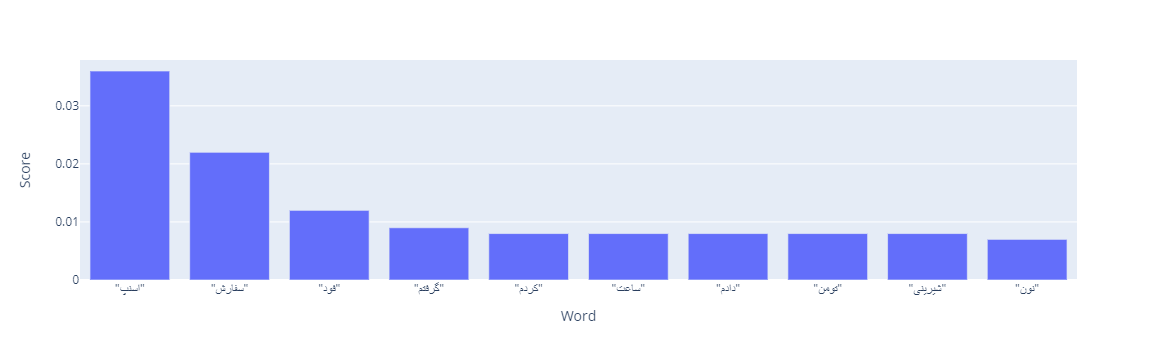

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



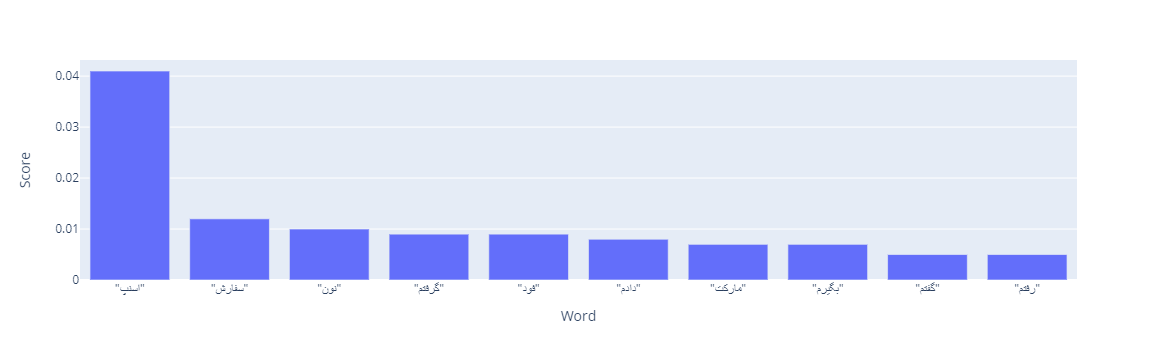

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



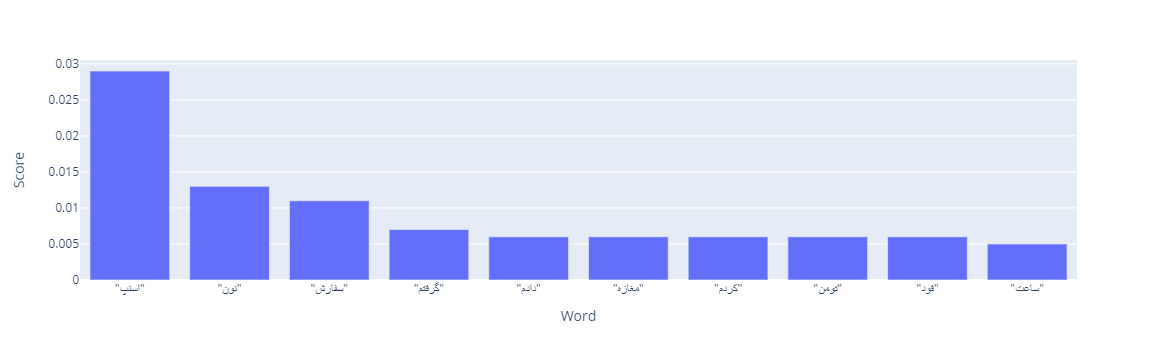

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



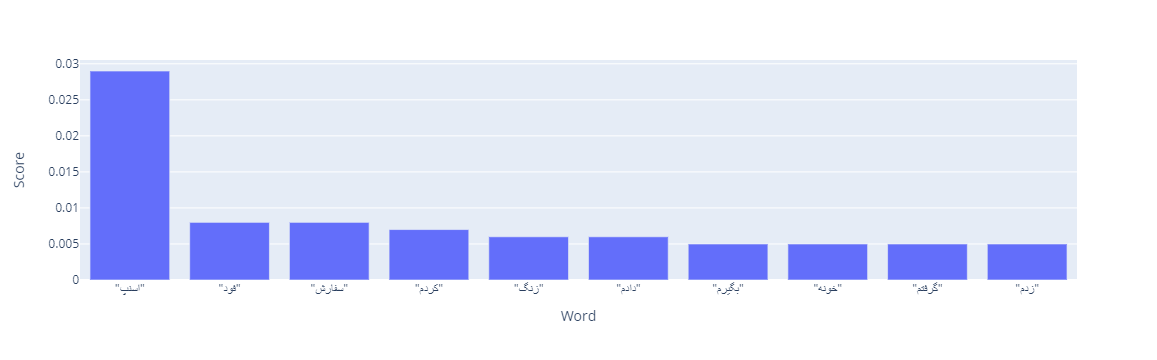

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/kourosh/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



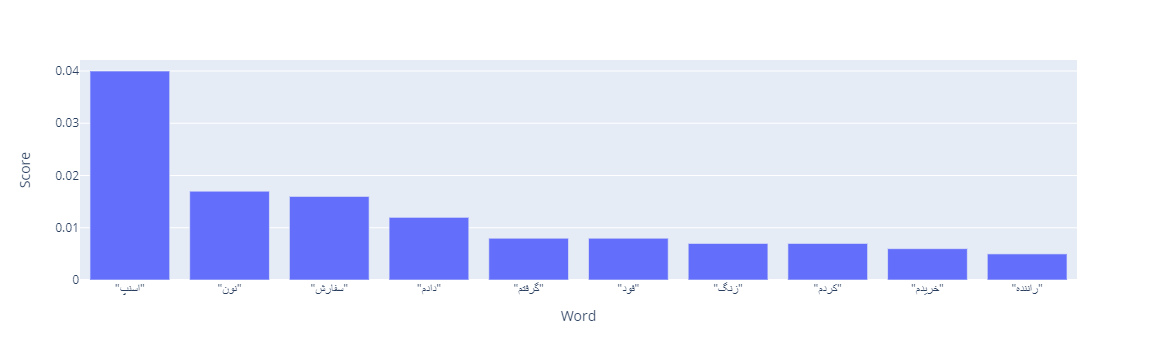

In [107]:
Themes = []
for i in range(num_topics):
    Themes.append([item.split('*') for item in lda_model.print_topics()[i][1].split(' + ')])
    
    df = pd.DataFrame(Themes[i], columns=['Score', 'Word'])
    df.Score = df.Score.astype(float)

    fig = px.bar(df, x='Word', y='Score')
    fig.show()